# Summary

### As the website is always changing, the scraped properties will be different from ours when running our codes now. Consequently, all the results produced by running our codes now will be different from our results. Hence, we also uploaded notebooks which illustrate the codes and results we had gotten.

### The assumend granularity of region in our report is postcode, because it can be efficiently derived from the scraped name of properties and it is the smallest area that we could efficiently carry out our further analysis.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression

## Website scraping and downlaoding external datasets

In [4]:
dls = "https://www.abs.gov.au/statistics/people/population/regional-population/2021/32180DS0003_2001-21.xlsx"
urllib.request.urlretrieve(dls, "../data/raw/population_2001-21.xlsx")

('population_2001-21.xlsx', <http.client.HTTPMessage at 0x7fe6054aca30>)

### The codes for this part are included in the notebook scrape.ipynb and download.ipynb in the notebooks folder.

Properties from the Domain website (https://www.domain.com.au/) were scraped using different sorting filters including properties with 1 bedroom, 2 bedrooms, 3 bedrooms, 4 bedrooms, 5+ bedrooms, featured properties, newest properties, lowest priced properties and highest priced properties. The original features scraped from each property included: property address (including postcode), advertised price, property coordinates, list of rooms (number of bedrooms, bathrooms, parking space), description of property, available date, property type (house, apartment, etc.) and a list containing distance(s) to the nearest school(s).

8012 raw property instances were initially downloaded.

Limitations:
- Limited amount of data on properties were scraped, which is not a good representation of property prices in each postcode. I.e. some postcodes contained only single instances of property price.

- Bias in property data from the search filters (e.g. highest priced properties).


## Distance calculating

### The codes for this part are included in the notebook proximity.ipynb in the notebooks folder.

We decided to calculate the distance of each property to the closest train station and to CBD (in meters) as two external features.  

### Distance to train stations

The coordinates of train station were derived by merging two external datasets from DATA VIC which include all the metropolitan and regional train station in Victoria (Annual_metropolitan_train_station_entries_2020-21.xlsx and Annual_regional_train_station_entries_2020-21.xlsx)

In order to imrpove the efficiency, we decided to use K-NN clustering setting K=2 to find the 2 geometrically closetest train station to each property in the read in dataset, and then find the closest distance by car out of the two selected stations using Open route services api. The reason of setting K=2 is that it performs much better by K=1 (find smaller distace) and is much faster to implement than K=3. API keys are stored in text files in our local computer to ensure the security. 

Limitations:
- The closest train station by car may not have been one of the two nearest neighbors calculated using Manhattan distancing
- The amount of API requests were limited to 2000 a day which delayed the distance calculations for CBD and Train stations.


### Distance to CBD

The distance by car to CBD from each property was again calculated using the Open Route Services API. Api keys are stored in text files in our local computer to ensure the security.

Limitations:
- The amount of API requests were limited to 2000 a day which delayed the distance calculations for CBD and Train stations.


## Population and income prediction

### The codes and results for this part are included in the notebook population_prediction.ipynb and income_prediction.ipynb in the notebooks folder.

Population and average yearly income per person are the other two external features. Those information was derived from the two external datasets which are population_2001-21.xlsx and ABSIncomeSA2.xlsx from Australian Burean of Statistics. However, as those two external datasets do not include data of current year, we just assumed that our predicted data of current is accurate and would be used as the training data of the prediction model (but is actually inaccurate). The final datasets containing the predicted next 3 years' population and median income were stored as csv files in curated folder with the name population_prediction.csv and income_prediction.csv respectively.

For population prediction, we assumed early years' data to be irrelevant and adopt the formula (P illustrates the value of population or income)  $$P_{next} = P_{current}*(1+\frac{P_{current}-P_{prev}}{P_{prev}+0.1})$$ to predict next year's population based on previous two years population. We add 0.1 to the denominator to prevent divided by 0 error. This approach appears to perform better than the built-in linear regrssion model which treat all the data from previous years as a whole and apply simple linear relationship.

We assumed that early years' data would be irrelevant to forecast data of next three years, so the formula is purely based on growth rate of only the previous two years.

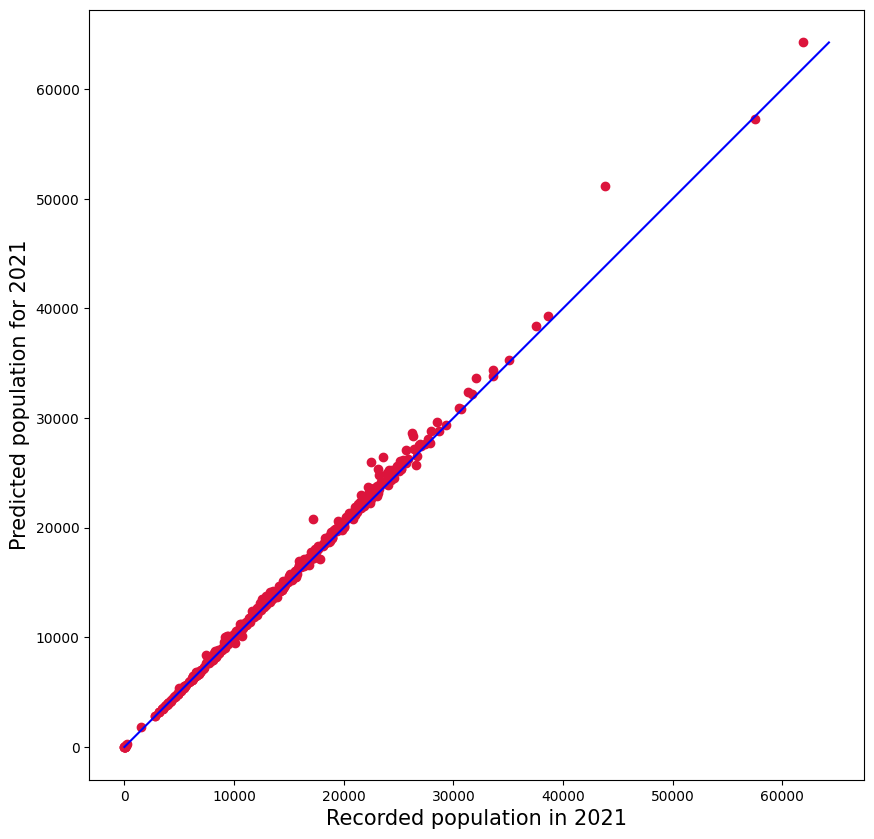

In [5]:
# Read population record from 2001-2021 from Excel file Table 1, skip first 6 irrelevant rows, and assign column names
df = pd.read_excel("../data/raw/population_2001-21.xlsx",sheet_name='Table 1',skiprows=6,header = 1)
# Filter the records in the state of Victoria
df_vic = df.loc[df['S/T name'] == 'Victoria']
# Due to the excel format, need to correct column name to true year record
df_vic = df_vic.rename(columns = {'no.':'2001','no..1':'2002','no..2':'2003','no..3':'2004','no..4':'2005',
                     'no..5':'2006','no..6':'2007','no..7':'2008','no..8':'2009','no..9':'2010',
                     'no..10':'2011','no..11':'2012','no..12':'2013','no..13':'2014','no..14':'2015',
                     'no..15':'2016','no..16':'2017','no..17':'2018','no..18':'2019',
                     'no..19':'2020','no..20':'2021','no..21':'2021-2020=','%':'2021-2020%'}, inplace = False)
# Drop irrelevant columns 
df_VIC = df_vic.drop(columns=['GCCSA code', 'GCCSA name', 'SA4 code',
       'SA4 name', 'SA3 code', 'SA3 name','Unnamed: 31'])
# Create a list of years 
YEAR_LIST = ['2001','2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020', '2021']
true_df = df_vic[['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020', '2021']]
predict_df = pd.DataFrame()
i = 0
while i<19:
    #plus one to avoid divided by zero error
    predict_df[YEAR_LIST[i+2]] = df_vic[YEAR_LIST[i+1]]*(1+(df_vic[YEAR_LIST[i+1]] - df_vic[YEAR_LIST[i]])/(df_vic[YEAR_LIST[i]]+1))
    i=i+1
          
predict_df_imputed = predict_df.fillna(0)
plt.figure(figsize=(10,10))
plt.scatter(true_df['2021'], predict_df_imputed['2021'], c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(predict_df_imputed['2021']), max(true_df['2021']))
p2 = min(min(predict_df_imputed['2021']), min(true_df['2021']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('')
plt.xlabel('Recorded population in 2021', fontsize=15)
plt.ylabel('Predicted population for 2021', fontsize=15)
plt.axis('equal')
plt.show()

# Compute the prediction for future three years and add 1 to avoid zeron in denominator
df_vic['p2013'] = df_vic['2012']*(1+(df_vic['2012'] - df_vic['2011'])/(df_vic['2011']+1))
df_vic['p2022'] = df_vic['2021']*(1+(df_vic['2021'] - df_vic['2020'])/(df_vic['2020']+1))
df_vic['p2023'] = df_vic['p2022']*(1+(df_vic['p2022'] - df_vic['2021'])/(df_vic['2021']+1))
df_vic['p2024'] = df_vic['p2023']*(1+(df_vic['p2023'] - df_vic['p2022'])/(df_vic['p2022']+1))


Based on the plot of 2021 population record and 2021 predicted population, the formula appeared to have performed quite well. With quite small mean squared errors.

Since we use the same formula to predict next 3 years' population and median income, each year's growth rate for population and median income will be same. 

## Preprocess

### Codes of this part are included in the notebook preprocess.ipynb in the notebooks folder.

 Basic preprocess was implemented to each property dataset and then merged all the datasets to be one final dataset.

At first, properties which do not provide information about the numbers of rooms and price were removed. Secondly, only useful features were selected. Then regular expression was used to derive postcodes from scraped names of properteis and to derive the numerical value of numbers of rooms, the distances to closest school and the prices of properties. Then the distances of each property to the closest train station and to CBD, which were stored in text files, were merged with the properties datasets. After the previous preprocess, all the properteis datasets were merged into one dataset removing all duplicate properties. This merged dataset contains 6754 properties in total.

Then the data of population and income were merged with the merged properteies dataset. As the data of population and income are in the granularity of SA2, we had to convert the granularity to postcode. The conversion was done by: for population, we decided to divide the whole population of an SA2 area to each postcode which belongs to that SA2 by the proportion of number of the properties in each postcode area; for income, we assumed that all the postcodes belong to one SA2 area have the same income data as that SA2 area; for postcodes which belong to multiple SA2 areas, we just added up the population and income of each SA2 area. However, it is obvious that inevitable inaccuracy was created by the process of conversion. 
Finally, the features in the final dataset are name, postcode, property_type, number of bedrooms, number of bathrooms, number of parking spaces, price, distance to the nearest train station (in meters), distance to CBD (in meters), distance to the nearest school (in km), population and income in current year, in 2023, in 2024 and in 2025. Then the final dataset was stored as a csv file in the curated folder with the name final2.csv

## Price normalization

### The codes for this part are included in the notebook price_clustering.ipynb in the notebooks folder.

Firstly, we assumed properties with rental price < $100 and > $100000 to be outliers and remove them.
Using K-means clustering from Sklearn, the prices where assigned to 4 separate clusters. One cluster was assumed to be the monthly price, another was assumed to be the annual price and the remaining two were assumed to be weekly prices (upper and lower end). Using these cluster labels and another assumption that monthly prices were within $2000 and $20000 and annual prices exceeded $20000, property prices were then standardized to price per week.

Limitations:
- Misclassification of price granularity using K-means clustering as there may have been price overlaps in clusters.

## Analysis

Firstly, postcode areas with population < 100 and average yearly income per person < $1000 and properties with 0 bedrooms were assumed as outliers which could affect the performance of feature selection and prediction mode. We removed them before further analysis. Codes for this part are included in the notebook preprocessing.ipynb in the notebook folder, which produced a file called `cleaned_df.csv` in data/curated folder.

### Feature selection

To fit the model properly, three scraped features are excluded.
1. Postcode is widely sparsed and treated as group instead of feature. Also its correlation with population and income is high;
2. Property description include too much agents' sujective positive sentiment, thereby biased;
3. Available date of current year is not meaningful for future price prediction.

We first analyse the linear correlation between features and rent by computing person correlation values.

In [12]:
# Read dataset from preprocessed to df
# cleaned_df.csv is preprocessed by removing outliers
df = pd.read_csv('../data/curated/cleaned_df.csv')
# Discard irrelevant columns and rename columns
df = df.drop(columns=['Unnamed: 0.1', 'index', 'Unnamed: 0','price_label']).rename(columns={'train_station(m)':'train_station_distance','CBD(m)':'CBD_distance','cost_text':'rent'})
corr_dict=dict()
numeric_col = ['bedrooms', 'bathrooms', 'parking',
       'schools', 'train_station_distance', 'CBD_distance',
       'population2022', 'population2023', 'population2024', 'population2025',
       'income2022', 'income2023', 'income2024', 'income2025']
for i in numeric_col:
    corr_dict[i] = df[i].corr(df['rent'])

dict(sorted(corr_dict.items(), key=lambda item: np.abs(item[1]),reverse=True))

{'bathrooms': 0.4598141680384162,
 'bedrooms': 0.42008904924219354,
 'parking': 0.2220591415977699,
 'population2024': -0.18846974417215406,
 'population2025': -0.1882070198371425,
 'population2023': -0.18796677975354625,
 'population2022': -0.18658795245915522,
 'income2023': -0.15988168770148392,
 'income2022': -0.15987851815515147,
 'income2024': -0.15940118391999042,
 'income2025': -0.15846222168064517,
 'CBD_distance': -0.10629345233836826,
 'train_station_distance': 0.08931865554979694,
 'schools': -0.0036236458006096736}

Above is a dictionary of Pearson correlation value between features and rent. We can see stronger linear correlation between number of bathrooms and bedrooms. Moreover, Absolute Pearson correlation value less than 0.3 suggests weak linear relationship between the other features and rent.

Then, we draw some scatter plots to gain a rough understanding of relationships between `rent` and other features.

Text(0.5, 1.0, 'property_type vs. rent')

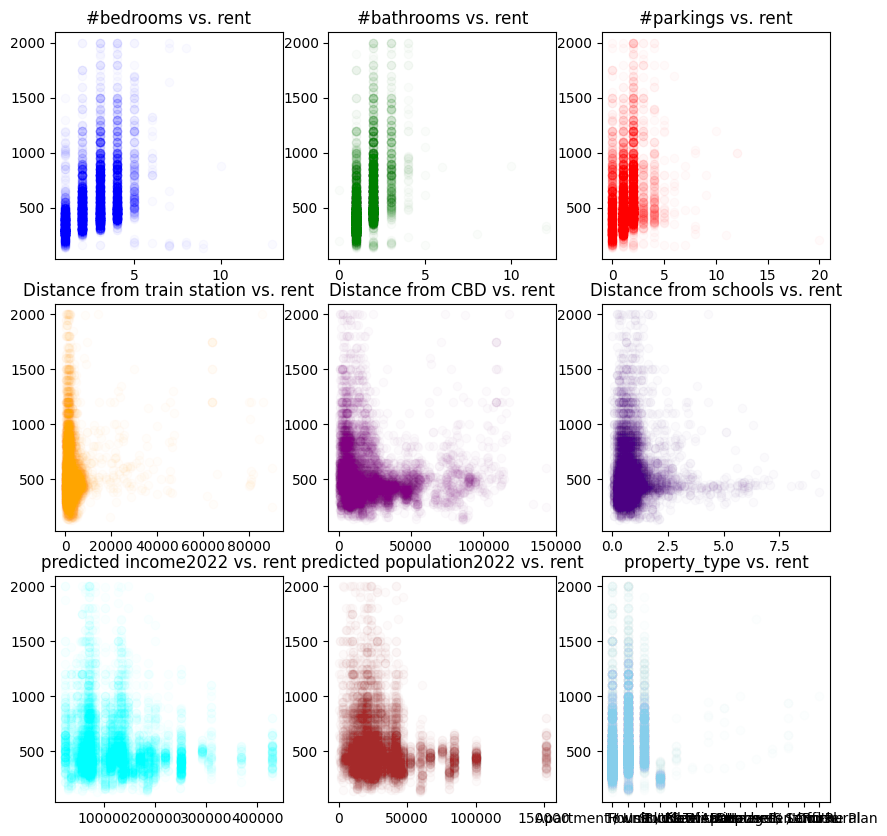

In [ ]:
alpha = 0.02
plt.figure(figsize=(10,10))

plt.subplot(331)
plt.scatter(df['bedrooms'],df.rent,color ='blue',alpha=alpha)
plt.title('#bedrooms vs. rent')

plt.subplot(332)
plt.scatter(df['bathrooms'],df.rent,color = 'green',alpha=alpha)
plt.title('#bathrooms vs. rent')

plt.subplot(333)
plt.scatter(df['parking'],df.rent,color = 'red',alpha=alpha)
plt.title('#parkings vs. rent')

plt.subplot(334)
plt.scatter(df['train_station_distance'],df.rent,color = 'orange',alpha=alpha)
plt.title('Distance from train station vs. rent')

plt.subplot(335)
plt.scatter(df['CBD_distance'],df.rent,color = 'purple',alpha=alpha)
plt.title('Distance from CBD vs. rent')

plt.subplot(336)
plt.scatter(df['schools'],df.rent,color = 'indigo',alpha=alpha)
plt.title('Distance from schools vs. rent')

plt.subplot(337)
plt.scatter(df['income2022'],df.rent,color = 'cyan',alpha=alpha)
plt.title('predicted income2022 vs. rent')

plt.subplot(338)
plt.scatter(df['population2022'],df.rent,color = 'brown',alpha=alpha)
plt.title('predicted population2022 vs. rent')

plt.subplot(339)
plt.scatter(df['property_type'],df.rent,color = 'skyblue',alpha=alpha)
plt.title('property_type vs. rent')


We can see from scatter plots in the first row that number of `bedroom`, `bathrooms` and `parkings` are ordinal variables. It is worth noting as the number of facilities increase, lower boundaries of rent increase significantly. Whereas the upper limit appear to have less significant increase.

### The codes and results for this part are included in the notebook feature selection（Anova test).ipynb in the notebooks folder.

Anova was implemented to determine if each internal and external variables has significant influence on rental price. And we stored the output of Anova in the curated folder with the name feature_selection.csv.

In [4]:
# Read the Anova output file
import pandas as pd
df_feature_selection = pd.read_csv("./data/curated/feature_selection.csv")
df_feature_selection

,Unnamed: 0,sum_sq,df,F,PR(>F)
0,C(property_type),4.004823e+06,14.0,6.637327,1.354623e-13
1,C(bedrooms),2.539828e+07,11.0,53.573437,4.080512e-114
2,C(bathrooms),3.151468e+07,9.0,81.247174,1.217086e-143
3,C(parking),2.815069e+06,13.0,5.024393,6.448718e-09
4,schools,1.110345e+06,1.0,25.762971,3.964761e-07
5,train_station,1.017019e+07,1.0,235.975557,2.320107e-52
6,CBD,2.228292e+07,1.0,517.023168,2.689856e-110
7,population2022,4.878717e+06,1.0,113.199226,3.164387e-26
8,income2022,7.001461e+05,1.0,16.245256,5.626814e-05
9,Residual,2.874239e+08,6669.0,NaN,NaN


The above table is the output of using Anova for feature selection. From the last column of the table, it can found that the p-value of all internal and external features are less than 0.05, which means all features have significant influence on rental price.
Hence, we concluded that useful internal features:property type, number of bedrooms, number of bathrooms, number of parking; useful external features: distance to the nearest school, distance to the nearest train station, distance to CBD, population, median income.

/home/yilinc4/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


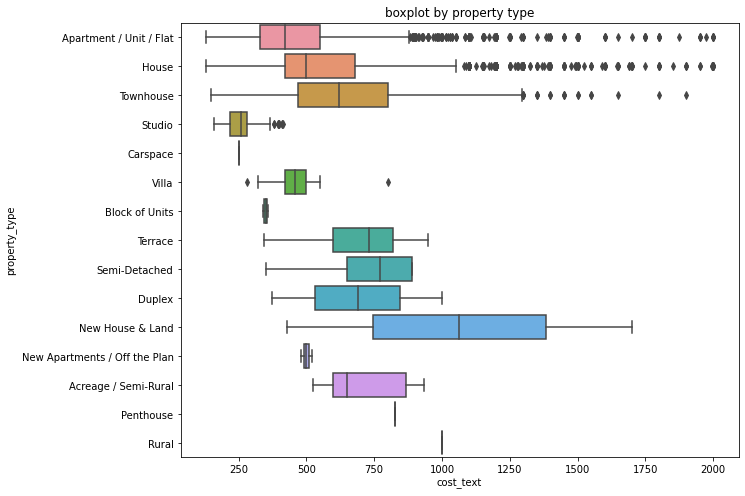

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df5 = pd.read_csv("../data/curated/price_normalised3.csv")
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot( 'cost_text', 'property_type', data=df5, ax=ax, orient='h')
plt.title('boxplot by property type')
#plt.xticks(rotation=90)
#plt.yticks(rotation=90)
plt.rc('font', size=15)
plt.savefig('../plots/boxplot2.png')

Above codes produce a boxplot of prices of properties by each property type. From the boxplot (our boxplot is included in the boxplot.ipynb), it can be seen that the feature property_type does have an impact on prices of properties. 

### Prediction model and model performance

### The codes and results for this part are included in the notebook model.ipynb in the notebooks folder.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras import backend as K
import numpy as np

df1_4 = pd.read_csv('../data/curated/cleaned_df.csv')
df1 = df1_4[['property_type', 'bedrooms', 'bathrooms', 'parking','schools', 'cost_text', \
    'train_station(m)', 'CBD(m)', 'population2022', 'income2022']]

# one-hot encoding for the categorical feature
df_dummy = pd.get_dummies(df1['property_type'], \
    prefix=['property_type'], drop_first=False, dummy_na=False)
df1_1 = pd.concat([df1, df_dummy], axis=1)
df1_1 = df1_1.drop(['property_type'], axis = 1)

X=df1_1.drop("cost_text", axis=1).values
y=df1_1[["cost_text"]].values

# use StandardScaler to standardise the data which can significantly improve the performance of the model
scaler = StandardScaler() 
# Generating the standardized values of X and y
X=scaler.fit_transform(X)
y=scaler.fit_transform(y)

# split the dataset to train and test datasets(used to test the performance of the model)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

# define metrics
def R2(y, y_hat):
    ss_res = K.sum(K.square(y - y_hat)) 
    ss_tot = K.sum(K.square(y - K.mean(y))) 
    return ( 1 - ss_res/(ss_tot + K.epsilon()) )

For the model of prediction, we decided to use neural network as it is quite useful for regression of non-linear correlation with hidden layers. The neural network we decided to built has 2 (avoid over-fitting) hidden layers both having 12 neurons and using Rectified Linear Unit (ReLU) function as the activation function. The ouput layer has only one neuron and linear function as activation function because our aim of the model is regression. There are nine selected features. However, after one-hot encoding the categorical feature property_type, 22 features in total are in the input layer of our neural network model. A graph illustrating the structure of our neural network model was also produced in model.ipynb. 

Moreover, standard scaler from sklearn was used to standardise training data, which significantly improved the performance of the prediction model. Adam was chosen to be the optimizer of the model. Mean squared error was chosen to be the loss function. R square was chosen to be a metrics. The model was trained using batch_size 64 and 197 epochs (we tried some different epochs and found 197 epochs was the best for us).

In [ ]:
# train and build the model using the training datasets
model = Sequential()
model.add(Dense(units=12, input_dim=22, kernel_initializer='normal', activation='relu'))
model.add(Dense(units=12, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[R2])
model.fit(X_train, y_train ,batch_size = 64, epochs = 197, verbose=1)

2022-10-08 18:44:23.085338: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-08 18:44:23.086435: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-08 18:44:23.086542: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (HP-SPECTRE-Pro3): /proc/driver/nvidia/version does not exist
2022-10-08 18:44:23.090426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/197
83/83 [==============================] - 4s 11ms/step - loss: 0.9883 - R2: 0.0210
Epoch 2/197
83/83 [==============================] - 1s 13ms/step - loss: 0.7114 - R2: 0.3033
Epoch 3/197
83/83 [==============================] - 1s 16ms/step - loss: 0.5772 - R2: 0.4344
Epoch 4/197
83/83 [==============================] - 1s 18ms/step - loss: 0.5409 - R2: 0.4633
Epoch 5/197
83/83 [==============================] - 1s 13ms/step - loss: 0.5194 - R2: 0.4776
Epoch 6/197
83/83 [==============================] - 1s 9ms/step - loss: 0.5016 - R2: 0.4973
Epoch 7/197
83/83 [==============================] - 1s 12ms/step - loss: 0.4875 - R2: 0.5201
Epoch 8/197
83/83 [==============================] - 1s 7ms/step - loss: 0.4770 - R2: 0.5337
Epoch 9/197
83/83 [==============================] - 1s 8ms/step - loss: 0.4696 - R2: 0.5354
Epoch 10/197
83/83 [==============================] - 1s 10ms/step - loss: 0.4641 - R2: 0.5389
Epoch 11/197
83/83 [==============================] - 1s 7ms/s

In [ ]:
predicted_re = model.predict(X_test)

# get the original data before standardise
p2 = np.int32(scaler.inverse_transform(predicted_re))

# get the original data before standardise
y_test_t = np.int32(scaler.inverse_transform(y_test))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


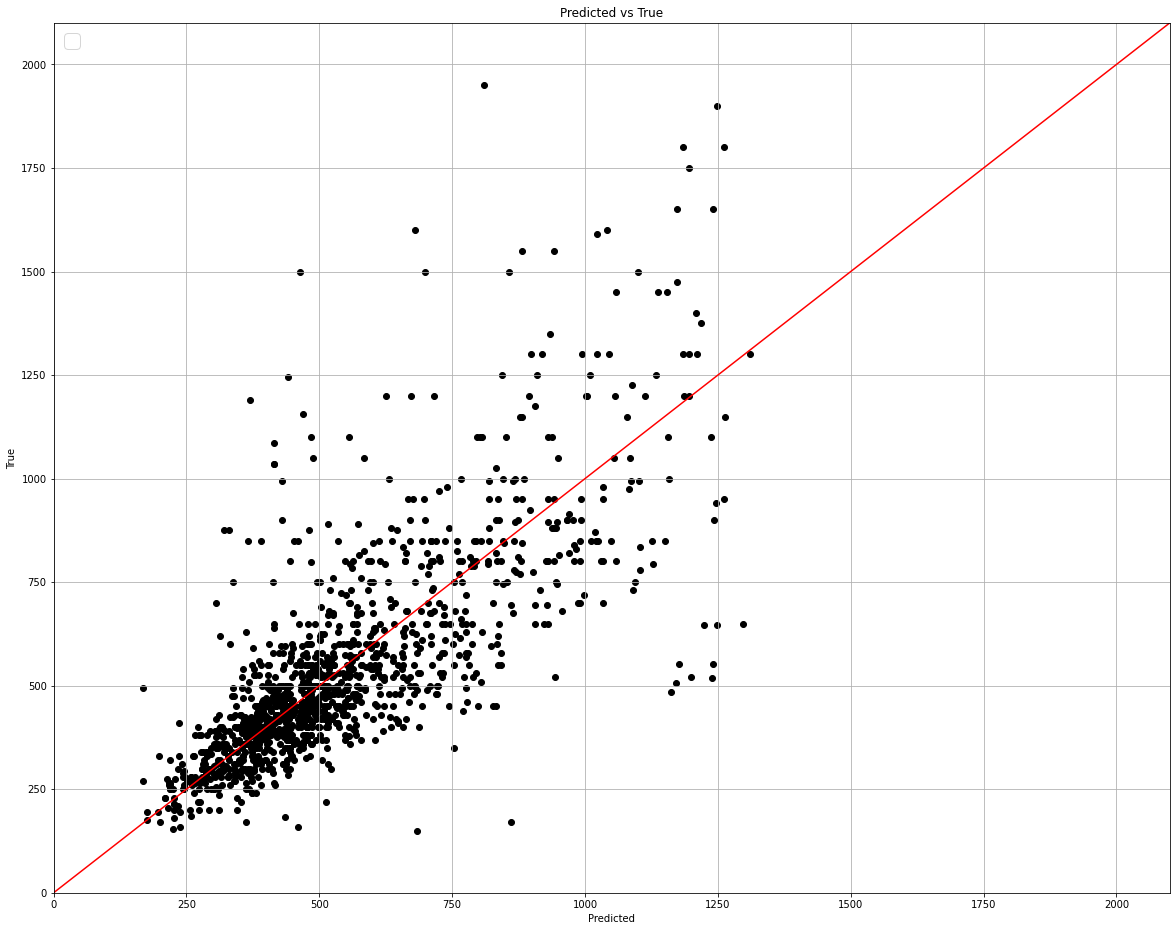

In [ ]:
# plot a scatter plot with predicted value vs true value using testing dataset
fig, ax = plt.subplots(figsize=(20,16))
from statsmodels.graphics.api import abline_plot
ax.scatter(p2, y_test_t, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax)
ax.grid(True)
ax.set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
ax.legend()
plt.xlim(0,2100)
plt.ylim(0,2100)
plt.savefig('../plots/predicted.png')
plt.show()

From the final values of MAE (0.3852) and R2 (0.6209), we can say that performance of the model is acceptable and satisfactory to us. Moreover, a scatter plot of true prices vs predicted prices of properteis in the test dataset (which is 20% of the whole training dataset chosen randomly) was sketched to check performance. From our plot, the performance of the model can still be considered as acceptable.

### Make prediction and calculate growth rate

### The codes and results for this part are also included in the notebook model.ipynb in the notebooks folder.

The property prices in 2025 were predicted by fitting the neural network model from before. The growth rate of the postcodes was found by calculating the difference in mean current price in each postcode and mean predicted price in each post code divided by the mean current price in each postcode. The formula to calculate growth rate for a postcode can seen by the following formula:

 $$Price_{change} =  \frac{\sum_{i=1}^{n} Price_{predicted}}{n} - \frac{\sum_{i=1}^{n} Price_{current}}{n}$$
Where n = number of properties in corresponding postcode
 $$Growth Rate = \frac{Price_{change}}{(\frac{\sum_{i=1}^{n} Price_{current}}{n})}$$
The postcodes were ranked highest to lowest based on growth rate

Limitation:
However, there is an issue here which can affect the accuracy of the prediction. That is: after getting the standardized values of the predicted prices of 2025 using the model, inverse standardization of those values can be inaccurate because we don't have the real values of future prices and can only use the scaler calculated using the values of current prices for inverse standardization. 

## Question2
### Top 10 suburbs with the highest predicted growth rate
### The codes and results for this part are included in the notebook top10_growth_rate.ipynb in the notebooks folder.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#read data
df = pd.read_csv('../data/curated/growth_rate3.csv')
df.head()
import geopandas as gpd
import folium
import seaborn as sns
sf = gpd.read_file("../data/raw/VMADMIN/POSTCODE_POLYGON.shp")
sf['centroid'] = sf['geometry'].apply(lambda x: (x.centroid.y, x.centroid.x))
# create a JSON 
postcode = []
for i in sf.iloc[:,1:2].values:
    postcode.append(int(i))
sf['postcode'] = postcode
geoJSON = sf[['postcode', 'geometry']].drop_duplicates('postcode').to_json()

/Users/weihaozhao/opt/anaconda3/envs/ads/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


We then grouped by each post code and calculated the average of the numerical data in order for further analysis.

In [2]:
# top 10 suburbs with highest growth rates 
df_top10_growth_rate = df.sort_values(by='growth_rate', axis=0, ascending=False).head(10)
df_top10_growth_rate

,post_code,growth_rate
0,3714,2.267857
1,3779,1.077143
2,3019,0.793766
3,3075,0.446740
4,3026,0.409205
5,3047,0.400249
6,3020,0.356444
7,3048,0.339016
8,3060,0.323021
9,3038,0.321212


The table shows the postcodes and their corresponding growth rates of the top 10 suburbs with highest growth rates.
The top2 postcodes only have one property in each one, so they might be outliers.

In [3]:
#merge the growth rate dataset with the postcode polygon dataset
post_code = []
for i in sf['POSTCODE']:
    post_code.append(int(str(i)))
sf['post_code'] = post_code
df_top10 = pd.merge(df_top10_growth_rate,sf,on = ['post_code'],how='left')

m3 = folium.Map(location=[-37.0,144], control_scale=True, zoom_start=7)

# create the map showing the predicted rate of all the postcodes
c3 = folium.Choropleth(
    geo_data=geoJSON,
    name='choropleth2', 
    data=df, 
    columns=['post_code','growth_rate'],
    key_on='properties.postcode',
    fill_color='YlOrRd',
    nan_fill_color='black',
    legend_name='growth_rate'
)

c3.add_to(m3)
df_copy = df_top10.copy()

#adding the green marker of top 10 suburbs
for i in range(0, len(df_copy)):
    html="""
    <h4> Postcode: </h4>""" + str(df_copy.iloc[i]['post_code'])+ \
    """<h4>Growth_rate:</h4>""" + str(df_copy.iloc[i]['growth_rate'])
    iframe = folium.IFrame(html=html, width=200, height=300)
    popup = folium.Popup(iframe, max_width=2650)
    folium.Marker(
        location=[df_copy.iloc[i]['centroid'][0],df_copy.iloc[i]['centroid'][1]],
        popup= popup,
        tooltip=str(df_copy.iloc[i]['post_code']),
        icon=folium.Icon(color='green',icon='home',prefix="fa"),
    ).add_to(m3)
    
#save the visualization of top 10 suburbs with highest pridicted grow rate in plots
import os
fig_save_path = "../plots/"
if not os.path.exists(fig_save_path):
    os.makedirs(fig_save_path)
m3.save(os.path.join(fig_save_path,"top 10 suburbs with the highest predicted growth rate.html"))

#### Since the map files are too large, so we did not upload them, and the maps would be saved into plots after running this cell.
This map shows the growth rates for each area in colour, The darker the colour means the higher the growth rate of the region, and the top ten are shown with the green marker. The black regions on the map represent that these suburbs do not have scraped properties.

## Question 3
### We then list the areas that are liveable and affordable for different demands, and our group assumed that affordable means lower rental prices.
### The codes and results for this part are included in the notebook affordable.ipynb and liveable.ipynb in the notebooks folder.
### liveable suburbs
### The codes and results for this part are included in the notebook liveable.ipynb in the notebooks folder.

In [4]:
import geopandas as gpd
import pandas as pd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
sf = gpd.read_file("../data/raw/VMADMIN/POSTCODE_POLYGON.shp")
sf['centroid'] = sf['geometry'].apply(lambda x: (x.centroid.y, x.centroid.x))
#read data
df = pd.read_csv('../data/curated/price_normalised3.csv')
df.head()
#group the data by postcode
df_1 = df.groupby('postcode').mean()
df_1['postcode'] = df_1.index
postcode = []
for i in sf.iloc[:,1:2].values:
    postcode.append(int(i))
sf['postcode'] = postcode
# create a JSON 
geoJSON = sf[['postcode', 'geometry']].drop_duplicates('postcode').to_json()

In [5]:
df_school = df_1.sort_values(by='schools', axis=0, ascending=True)
df_top5_school_distance = df_school.head()
df_school[['schools','cost_text']].head()
# top  5 suburb has shortest distance to school
# liveable for family that has kids

,schools,cost_text
postcode,,
3089,0.1,470.0
3022,0.1,450.0
3779,0.2,350.0
3713,0.2,425.0
3919,0.3,390.0


### The suburbs that has shortest distance to school would be liveable for the family that has kids, and in these top 5 suburbs, postcode 3779 has the lowest rent cost.

In [6]:
post_code = []
for i in sf['POSTCODE']:
    post_code.append(int(str(i)))
sf['postcode'] = post_code
df_top5_school_distance = df_top5_school_distance.reset_index(drop=True)
#merge the two dataset with the same postcode
df_top5_school_distance = pd.merge(df_top5_school_distance,sf,on = ['postcode'],how='left')
m = folium.Map(location=[-37.0,144], control_scale=True, zoom_start=7)

# The shortest distance to school in each suburb
c = folium.Choropleth(
    geo_data=geoJSON, 
    name='choropleth1', 
    data=df_1, 
    columns=['postcode','schools'], 
    key_on='properties.postcode', 
    fill_color='YlOrRd', 
    nan_fill_color='black',
    legend_name='top 5 suburbs have shortest school distance'
)

c.add_to(m)

df_copy = df_top5_school_distance.copy()
#add green marker of top 5
for i in range(0, len(df_copy)):
    html="""
    <h4> Postcode: </h4>""" + str(df_copy.iloc[i]['postcode'])+ \
    """<h4>Distance closest school:</h4>""" + str(df_copy.iloc[i]['schools'])
    iframe = folium.IFrame(html=html, width=200, height=300)
    popup = folium.Popup(iframe, max_width=2650)
    folium.Marker(
        location=[df_copy.iloc[i]['centroid'][0],df_copy.iloc[i]['centroid'][1]],
        popup= popup,
        tooltip=str(df_copy.iloc[i]['postcode']),
        icon=folium.Icon(color='green',icon='home',prefix="fa"),
    ).add_to(m)

#save this plot in plots
import os
fig_save_path = "../plots/"
if not os.path.exists(fig_save_path):
    os.makedirs(fig_save_path)
m.save(os.path.join(fig_save_path,"top 5 shortest school distance.html"))

#### After running this cell, we could get the geoviusalization of distance to school in each postcode, and it would be saved in plots.

In [7]:
df_CBD = df_1.sort_values(by='CBD(m)', axis=0, ascending=True)
df_CBD[['CBD(m)','cost_text']].head()
# top  5 suburb has shortest distance to CBD
# liveable for youths and people working in city

,CBD(m),cost_text
postcode,,
3000,1021.660279,595.713214
3053,1679.603540,541.752212
3003,1900.453846,606.282051
3006,2485.819868,708.586347
3002,2502.200000,765.756410


#### Young people and people working in the city love living close to CBD, so the suburbs that close to CBD would be liveable for them, and here are the top5 suburbs closest to CBD.

In [8]:
df_CBD = df_CBD.head()
df_CBD = df_CBD.reset_index(drop=True)
df_CBD = pd.merge(df_CBD,sf,on = ['postcode'],how='left')
m1 = folium.Map(location=[-37.0,144], control_scale=True, zoom_start=7)

# The distance to CBD in each suburb
c = folium.Choropleth(
    geo_data=geoJSON, 
    name='choropleth1', 
    data=df_1, 
    columns=['postcode','CBD(m)'], 
    key_on='properties.postcode', 
    fill_color='YlOrRd', 
    nan_fill_color='black',
    legend_name='top 5 suburbs closest to CBD'
)

c.add_to(m1)

df_copy = df_CBD.copy()

for i in range(0, len(df_copy)):
    html="""
    <h4> Postcode: </h4>""" + str(df_copy.iloc[i]['postcode'])+ \
    """<h4>Distance closest CBD:</h4>""" + str(df_copy.iloc[i]['CBD(m)'])
    iframe = folium.IFrame(html=html, width=200, height=300)
    popup = folium.Popup(iframe, max_width=2650)
    folium.Marker(
        location=[df_copy.iloc[i]['centroid'][0],df_copy.iloc[i]['centroid'][1]],
        popup= popup,
        tooltip=str(df_copy.iloc[i]['postcode']),
        icon=folium.Icon(color='green',icon='home',prefix="fa"),
    ).add_to(m1)

import os
fig_save_path = "../plots/"
if not os.path.exists(fig_save_path):
    os.makedirs(fig_save_path)
m1.save(os.path.join(fig_save_path,"top 5 closest CBD.html"))

#### After running this cell, we could get the geoviusalization of distance to CBD in each postcode, and it would be saved in plots.

In [9]:
df_train = df_1.sort_values(by='train_station(m)', axis=0, ascending=True)
df_train[['train_station(m)','cost_text']].head()
# top  5 suburb has shortest distance to train station
#liveable for people who need to take public transport in daily life, work or study 
#liveable for elders

,train_station(m),cost_text
postcode,,
3919,582.500000,390.000000
3143,582.817857,576.703297
3003,701.069231,606.282051
3000,729.649129,595.713214
3141,749.183871,626.924566


#### Closest to train station are especially sought after by people who need to take public transport in daily life, work or study. As well as the elders for whom walking too far becomes inconvenient for them.

In [10]:
df_train = df_train.head()
df_train = df_train.reset_index(drop=True)
df_train = pd.merge(df_train,sf,on = ['postcode'],how='left')
m2 = folium.Map(location=[-37.0,144], control_scale=True, zoom_start=7)

# The distance to train station in each suburb
c = folium.Choropleth(
    geo_data=geoJSON, 
    name='choropleth1', 
    data=df_1, 
    columns=['postcode','train_station(m)'], 
    key_on='properties.postcode', 
    fill_color='YlOrRd', 
    nan_fill_color='black',
    legend_name='Top 5 postcodes closest to Train Station'
)

c.add_to(m2)

df_copy = df_train.copy()

for i in range(0, len(df_copy)):
    html="""
    <h4> Postcode: </h4>""" + str(df_copy.iloc[i]['postcode'])+ \
    """<h4>Distance closest train station:</h4>""" + str(df_copy.iloc[i]['train_station(m)'])
    iframe = folium.IFrame(html=html, width=200, height=300)
    popup = folium.Popup(iframe, max_width=2650)
    folium.Marker(
        location=[df_copy.iloc[i]['centroid'][0],df_copy.iloc[i]['centroid'][1]],
        popup= popup,
        tooltip=str(df_copy.iloc[i]['postcode']),
        icon=folium.Icon(color='green',icon='home',prefix="fa"),
    ).add_to(m2)

import os
fig_save_path = "../plots/"
if not os.path.exists(fig_save_path):
    os.makedirs(fig_save_path)
m2.save(os.path.join(fig_save_path,"top 5 closest train station.html"))

#### After running this cell, we could get the geoviusalization of distance to train station in each postcode, and it would be saved in plots.
From the map we could see that the top5 suburbs have closest distances to train station mainly fall into city of Melbourne, and 3000 appears for the 3rd time in these three cases.

### Affordable suburbs
### The codes and results for this part are included in the notebook affordable.ipynb in the notebooks folder.
#### Our group assumed that affordable means lower rental prices.

In [11]:
import geopandas as gpd
import pandas as pd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
sf = gpd.read_file("../data/raw/VMADMIN/POSTCODE_POLYGON.shp")
sf['centroid'] = sf['geometry'].apply(lambda x: (x.centroid.y, x.centroid.x))
#read data
df = pd.read_csv('../data/curated/price_normalised3.csv')
#group the data by postcode
df_1 = df.groupby('postcode').mean()
postcode = []
for i in sf.iloc[:,1:2].values:
    postcode.append(int(i))
sf['postcode'] = postcode
# create a JSON 
geoJSON = sf[['postcode', 'geometry']].drop_duplicates('postcode').to_json()

df_affordable = df_1.sort_values(by='cost_text', axis=0, ascending=True)
df_affordable['postcode'] = df_affordable.index
df_top5_affordable = df_affordable.head()
df_top5_affordable[['cost_text']]
# top  5 suburb has lowest rent
# affordabel for poor family

,cost_text
postcode,
3717,250.000000
3714,280.000000
3085,289.908524
3061,322.500000
3175,332.230769


####  We find the top5 suburbs with lowest rent.

In [12]:
post_code = []
for i in sf['POSTCODE']:
    post_code.append(int(str(i)))
sf['postcode'] = post_code
df_top5_affordable = df_top5_affordable.reset_index(drop=True)
#merge the two dataset with the same postcode
df_top5_affordable= pd.merge(df_top5_affordable,sf,on = ['postcode'],how='left')
m2 = folium.Map(location=[-37.0,144], control_scale=True, zoom_start=7)

# The average rent of each suburb
c2 = folium.Choropleth(
    geo_data=geoJSON,
    name='choropleth2', 
    data=df_affordable, 
    columns=['postcode','cost_text'],
    key_on='properties.postcode',
    fill_color='YlOrRd',
    nan_fill_color='black',
    legend_name='num_of_properties'
)

c2.add_to(m2)
df_copy = df_top5_affordable.copy()

for i in range(0, len(df_copy)):
    html="""
    <h4> Postcode: </h4>""" + str(df_copy.iloc[i]['postcode'])+ \
    """<h4>Growth_rate:</h4>""" + str(df_copy.iloc[i]['cost_text'])
    iframe = folium.IFrame(html=html, width=200, height=300)
    popup = folium.Popup(iframe, max_width=2650)
    folium.Marker(
        location=[df_copy.iloc[i]['centroid'][0],df_copy.iloc[i]['centroid'][1]],
        popup= popup,
        tooltip=str(df_copy.iloc[i]['postcode']),
        icon=folium.Icon(color='green',icon='home',prefix="fa"),
    ).add_to(m2)
    
#save plot
import os
fig_save_path = "../plots/"
if not os.path.exists(fig_save_path):
    os.makedirs(fig_save_path)
m2.save(os.path.join(fig_save_path,"top 5 postcodes with lowest rent.html"))

#### After running this cell, we could get the geoviusalization of rent prices in each postcode, and it would be saved in plots. From the table we could see that the postcode 3717 and 3714 have the lowest rent, and they are at the North East area of Victoria, so we could conclude that North-East Victoria is the cheapest and most affordable area.